# Compare models to select the best hyperparameters
This tutorial will review AMPL functions for visualizing the results of a hyperparameter search in order to find the optimal hyperparameters for your model.

After performing a hyperparameter search, it is prudent to examine each hyperparameter in order to determine the best combination before training a production model with all of the data. Additionally, it is good to explore the different performance metrics.

For the purposes of this tutorial, I simply ran `tutorial 6` three times to get enough models for comparison.

### Import packages

In [57]:
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Get model results
First we pull the results of the hyperparameter search into a dataframe. In `tutorial 6` we used `get_filesystem_perf_results()` which packs hyperparameters in a dict in the column `model_parameters_dict`. Here we use the individual hyperparameter columns to create visualizations.  

In [59]:
result_df=cm.get_filesystem_perf_results(result_dir='tmp_kcna3_rdkit_raw/', pred_type='regression')
result_df=result_df.sort_values('best_valid_r2_score', ascending=False)
result_df.head(2)

Found data for 230 models under tmp_kcna3_rdkit_raw/


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,...,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
63,b5d13c11-87ba-4941-90b9-eac8c184e90f,tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_b...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,r2,normalization,0.732181,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 69, ""rf_max_depth"": 22, ""rf_...",{}
11,77845fea-3d50-4bc3-bb5f-cc51c661a77d,tmp_kcna3_rdkit_raw/curated_kcna3_ic50_model_7...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,r2,normalization,0.730707,...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 91, ""rf_max_depth"": 29, ""rf_...",{}


In [3]:
# filter out objectively bad performing models
result_df=result_df[result_df.best_valid_r2_score>0]
result_df.shape

(130, 34)

### Visualize hyperparameters
There are several plotting functions in the `hyper_perf_plots` module that help visualize the different combinations of features for each type of model.

`plot_train_valid_test_scores()` gives a quick snapshot of your overall model performance. You can see if you overfitted and get a sense of whether your partitions are a good representation of future performance. Here we see that the validation set scores are consistently lower than the test scores due to the nature of scaffold splitting. This might be a red flag that should be investigated further. The scoretype can also be changed to get a sense of whether r2_score or another metric is best for evaluation.

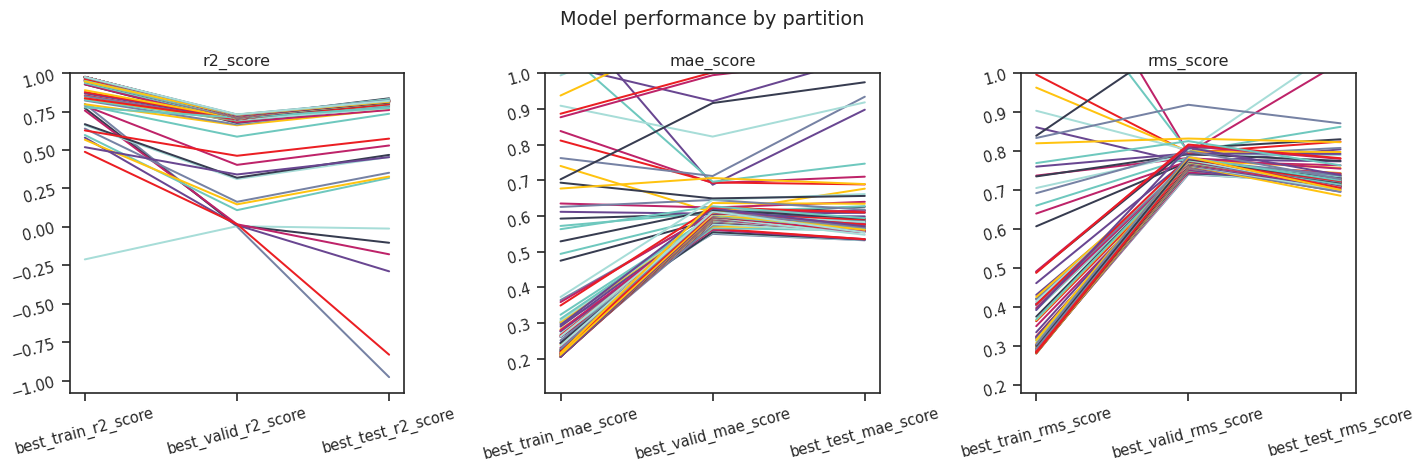

In [4]:
import importlib
importlib.reload(hpp)
hpp.plot_train_valid_test_scores(result_df, prediction_type='regression')

`plot_split_perf()` plots the performance of each split type, separated by feature type, for each performance metric.

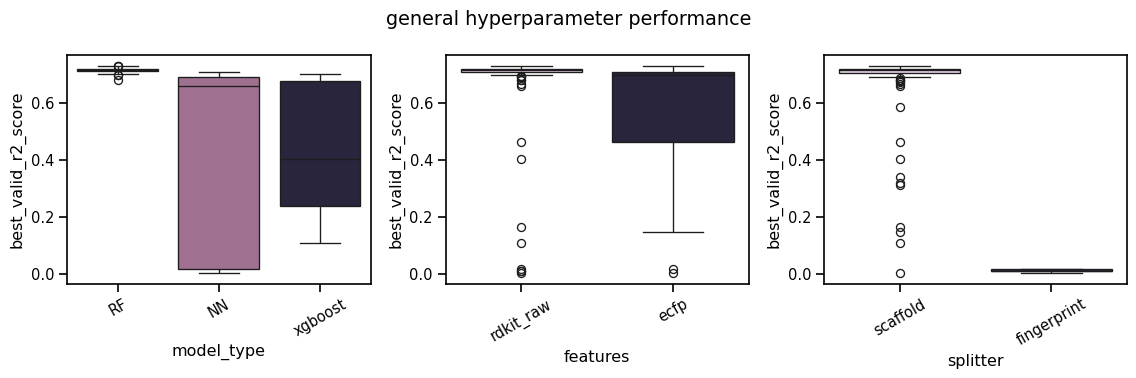

In [5]:
importlib.reload(hpp)
hpp.plot_hyper_perf(result_df)

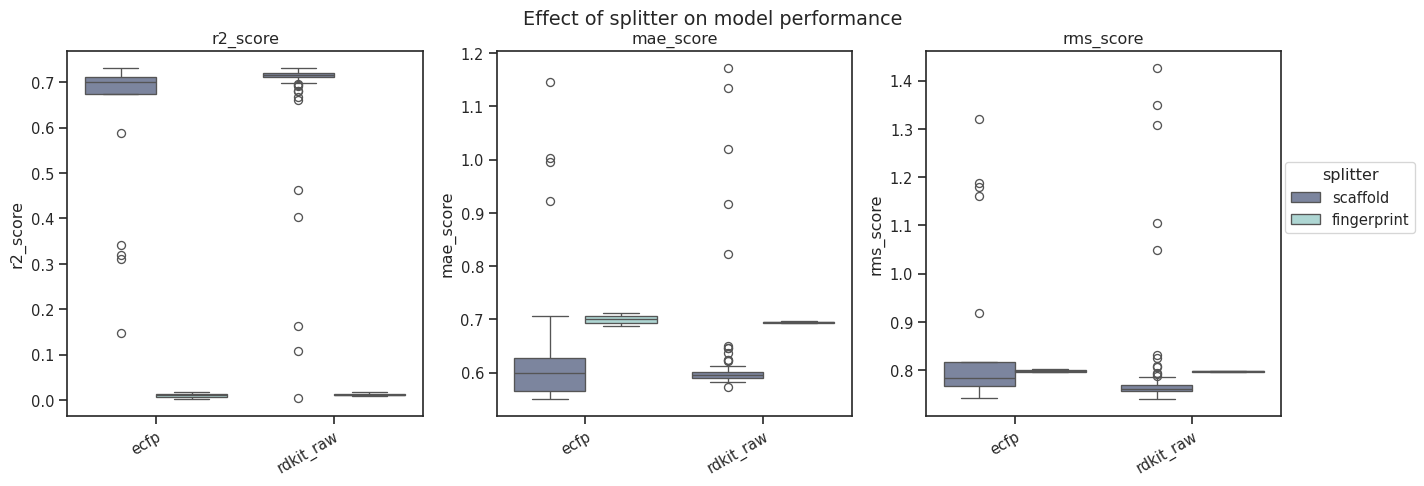

In [42]:
importlib.reload(hpp)
hpp.plot_split_perf(result_df, scoretype='r2_score', subset='valid')

`plot_rf_perf()` creates a scatter plot of the features/max_depth on the x-axis and the score on the y-axis. It is colored by number of trees. This plot works better when performing a grid search but is included here for demonstration purposes. There is also a verson for NN and XGboost models that review some of the top hyperparameters there.

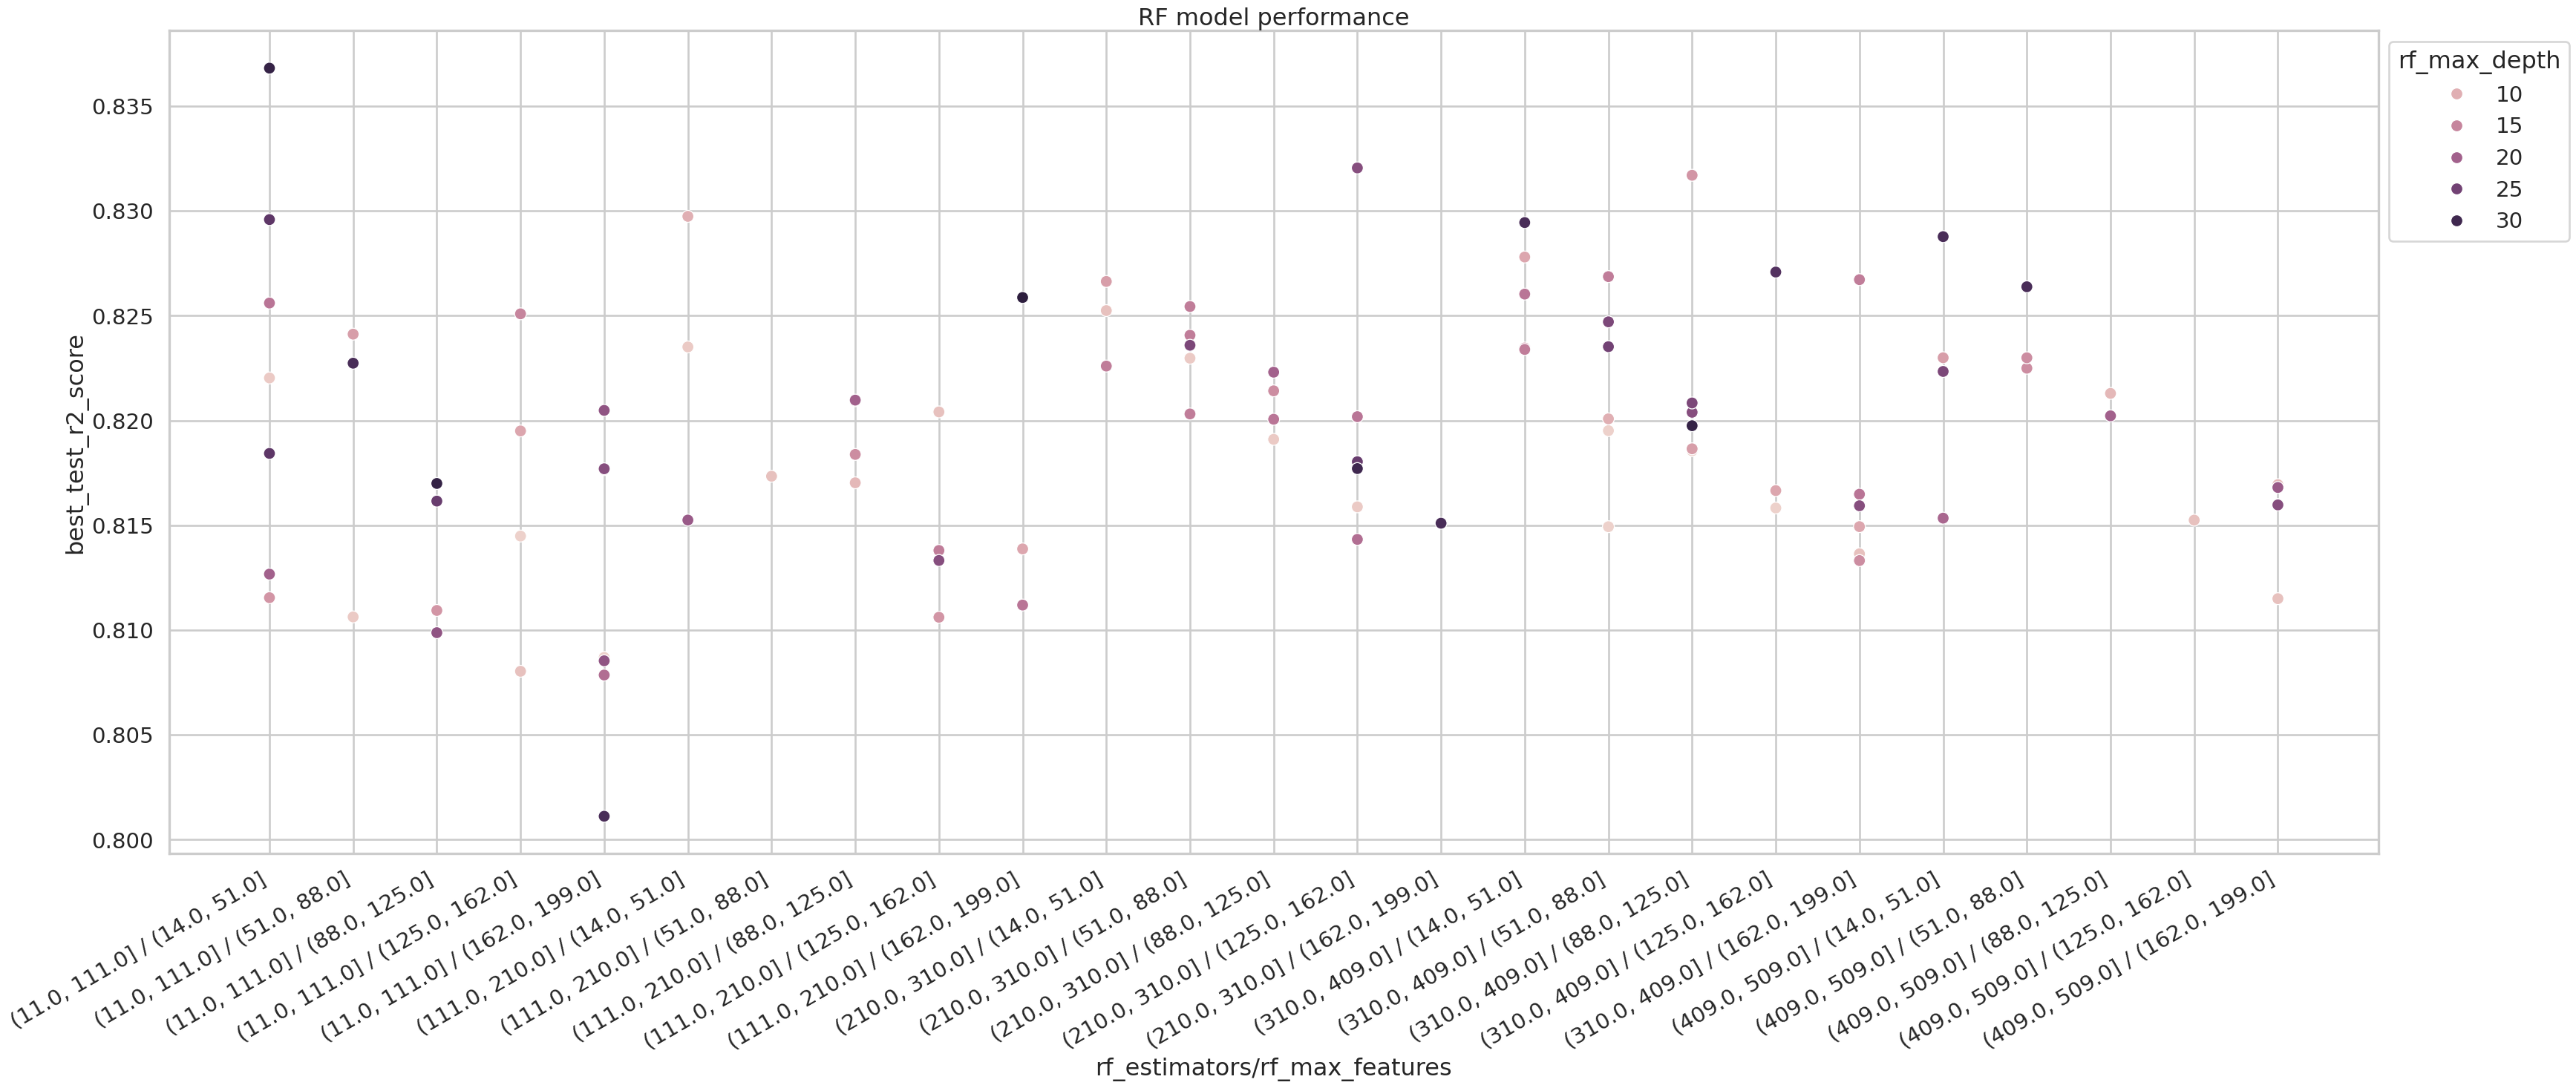

In [43]:
importlib.reload(hpp)
hpp.plot_rf_perf(result_df, scoretype='r2_score', subset='test')

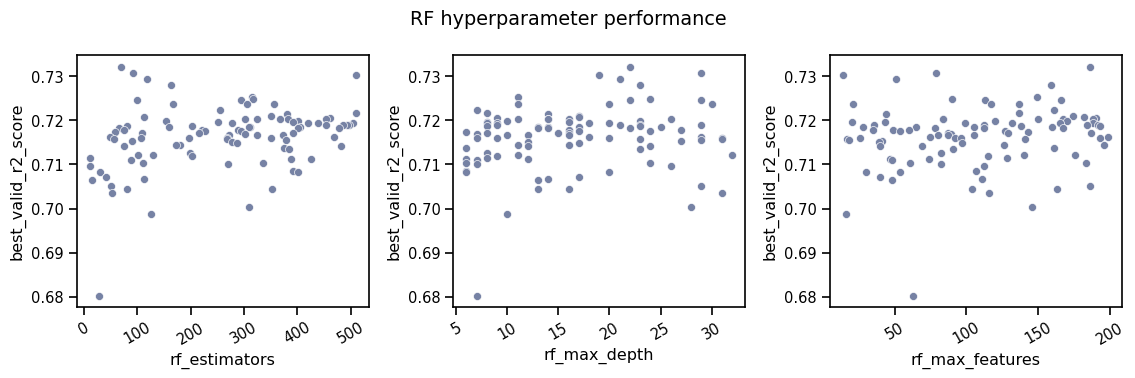

In [44]:
hpp.plot_hyper_perf(result_df, model_type='RF')

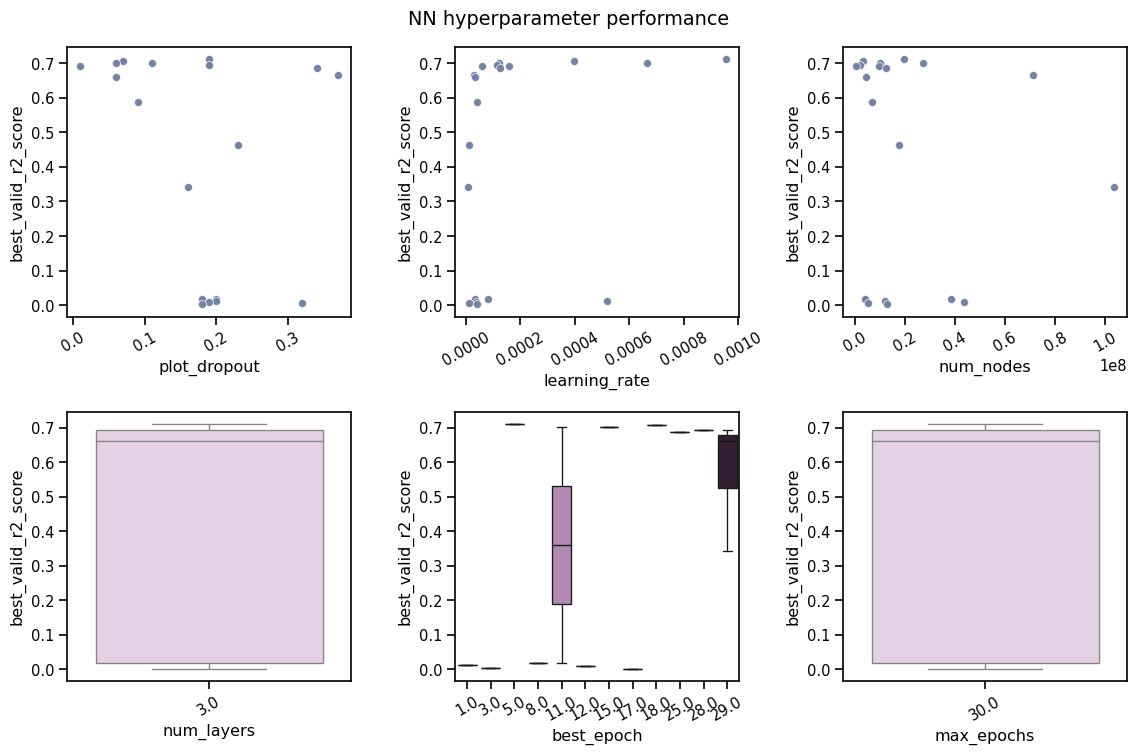

In [56]:
importlib.reload(hpp)
df=hpp.plot_hyper_perf(result_df, model_type='NN')

In [55]:
nns=df[df.model_type=='NN']
nns=nns.dropna(how='all', axis='columns')
nns.model_parameters_dict.iloc[0]

'{"best_epoch": 5, "dropouts": [0.1936760073738666, 0.2554091061869368, 0.15845003008198577], "layer_sizes": [388, 114, 439], "learning_rate": 0.0009565105850688984, "max_epochs": 30}'

In [ ]:
importlib.reload(hpp)
plot_df=hpp.plot_nn_perf(result_df, scoretype='r2_score', subset='test')

In [99]:
# plot_df.num_nodes=plot_df.num_nodes.round(3)
# plot_df=plot_df.style.format({'num_nodes': "{:.2E}"})
# plot_df[['nnc1','nnc2']]=plot_df.num_nodes_cut.astype(str).str.split(',')
import pandas as pd
feat1 = 'num_nodes'; feat2 = 'learning_rate';
for feat in [feat1,feat2]:
    plot_df[f'{feat}_cut']=pd.cut(plot_df[feat],5)
    bins=['{:.2e}'.format(x) for x in pd.cut(plot_df[feat],5,retbins=True)[1]]
    binstrings=[]
    for i,bin in enumerate(bins):
        try:binstrings.append(f'({bin}, {bins[i+1]}]')
        except:pass
    nncmap=dict(zip(plot_df[feat].dtype.categories.tolist(),binstrings))
    plot_df[f'{feat}_cut']=plot_df[f'{feat}_cut'].map(nncmap)

AttributeError: 'numpy.dtype[float64]' object has no attribute 'categories'

In [93]:
feat

'learning_rate'

In [95]:
plot_df[f'{feat}_cut']=pd.cut(plot_df[feat],5)
bins=['{:.2e}'.format(x) for x in pd.cut(plot_df[feat],5,retbins=True)[1]]
bins

['6.81e-06', '1.98e-04', '3.87e-04', '5.77e-04', '7.67e-04', '9.57e-04']

In [97]:
nncmap

{'(2.78e+05, 2.10e+07]': '(6.81e-06, 1.98e-04]',
 '(2.10e+07, 4.16e+07]': '(1.98e-04, 3.87e-04]',
 '(4.16e+07, 6.22e+07]': '(3.87e-04, 5.77e-04]',
 '(6.22e+07, 8.28e+07]': '(5.77e-04, 7.67e-04]',
 '(8.28e+07, 1.03e+08]': '(7.67e-04, 9.57e-04]'}

The column `best_valid_r2_score` contains the validation set R2_score which determines how we select the best model. The column `model_parameters_dict` contains hyperparamters used for the best model. We can visualize this model using `plot_pred_vs_actual_from_file`.

In [22]:
result_df.iloc[0].best_valid_r2_score

0.0021825888235730284

In [6]:
result_df.iloc[0].model_parameters_dict

'{"rf_estimators": 91, "rf_max_depth": 29, "rf_max_features": 79}'

In [ ]:
import atomsci.ddm.pipeline.perf_plots as pp

model_path=result_df.iloc[0].model_path

pp.plot_pred_vs_actual_from_file(model_path)

In [36]:
import seaborn as sns
sns.move_legend?

Signature: sns.move_legend(obj, loc, **kwargs)
Docstring:
Recreate a plot's legend at a new location.

The name is a slight misnomer. Matplotlib legends do not expose public
control over their position parameters. So this function creates a new legend,
copying over the data from the original object, which is then removed.

Parameters
----------
obj : the object with the plot
    This argument can be either a seaborn or matplotlib object:

    - :class:`seaborn.FacetGrid` or :class:`seaborn.PairGrid`
    - :class:`matplotlib.axes.Axes` or :class:`matplotlib.figure.Figure`

loc : str or int
    Location argument, as in :meth:`matplotlib.axes.Axes.legend`.

kwargs
    Other keyword arguments are passed to :meth:`matplotlib.axes.Axes.legend`.

Examples
--------

.. include:: ../docstrings/move_legend.rst
File:      ~/atomsci/lib/python3.9/site-packages/seaborn/utils.py
Type:      function

[Text(-20000000.0, 0, '−0.2'),
 Text(0.0, 0, '0.0'),
 Text(20000000.0, 0, '0.2'),
 Text(40000000.0, 0, '0.4'),
 Text(60000000.0, 0, '0.6'),
 Text(80000000.0, 0, '0.8'),
 Text(100000000.0, 0, '1.0'),
 Text(120000000.0, 0, '1.2')]

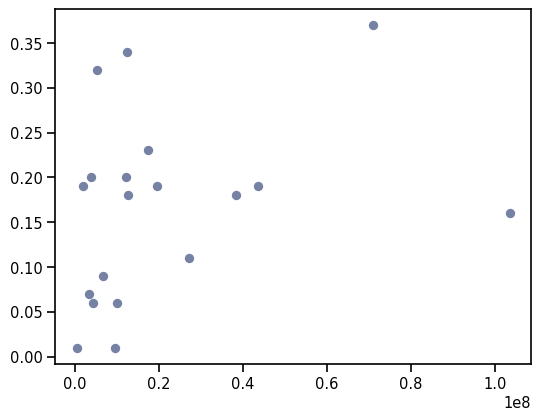

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
ax.scatter(data=plot_df,  x='num_nodes', y='plot_dropout')

ax.get_xticklabels()

In [45]:
from atomsci.ddm.pipeline import parameter_parser as pp

In [68]:
d=vars(pp.get_parser().parse_args())

In [69]:
keywords=['AttentiveFPModel','GCNModel','GraphConvModel','MPNNModel','PytorchMPNNModel','rf_','xgb_']
plot_dict={}
for word in keywords:
    tmplist=[x for x in d.keys() if x.startswith(word)]
    if word=='rf_': word='RF'
    elif word=='xgb_':word='xbgoost'
    plot_dict[word]=tmplist
plot_dict['general']=['model_type','features','ecfp_radius','splitter']
plot_dict['NN']=['plot_dropout','learning_rate','num_nodes','num_layers','weight_decay_penalty_type','weight_decay_penalty']

In [70]:
plot_dict

{'AttentiveFPModel': ['AttentiveFPModel_num_layers',
  'AttentiveFPModel_regularization_loss',
  'AttentiveFPModel_wandb',
  'AttentiveFPModel_n_classes',
  'AttentiveFPModel_loss',
  'AttentiveFPModel_batch_size',
  'AttentiveFPModel_output_types',
  'AttentiveFPModel_log_frequency',
  'AttentiveFPModel_model',
  'AttentiveFPModel_number_atom_features',
  'AttentiveFPModel_device',
  'AttentiveFPModel_graph_feat_size',
  'AttentiveFPModel_wandb_logger',
  'AttentiveFPModel_optimizer',
  'AttentiveFPModel_num_timesteps',
  'AttentiveFPModel_dropout',
  'AttentiveFPModel_self_loop',
  'AttentiveFPModel_tensorboard',
  'AttentiveFPModel_number_bond_features'],
 'GCNModel': ['GCNModel_regularization_loss',
  'GCNModel_wandb',
  'GCNModel_n_classes',
  'GCNModel_loss',
  'GCNModel_graph_conv_layers',
  'GCNModel_batch_size',
  'GCNModel_output_types',
  'GCNModel_log_frequency',
  'GCNModel_model',
  'GCNModel_number_atom_features',
  'GCNModel_device',
  'GCNModel_activation',
  'GCNModel